In [50]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import os

DATASET_IMAGE_DIRECTORY = "../dataset/images/"
DATASET_LABEL_DIRECTORY = "../dataset/labels/"

In [51]:
# ================================================================================
# get_line_info -> Transformar uma linha do arquivo texto para o objeto padrão.
# ================================================================================

def get_line_info(file_name : str, line : str) -> dict:
    # Saída ->
    # filename
    # width
    # height
    # class
    # xmin
    # ymin
    # xmax
    # ymax    
    if line is None:
        return None
    
    columns = line.split(' ')
    
    if len(columns) != 14:
        return None

    frame_size = { 'width' : 640, 'height' : 360 }

    return { "filename" : file_name,
             "width" : 640,
             "height" : 360,
             "class" : int(columns[3]) + 1,
             "xmin" : np.min([np.min([int(columns[6]), int(frame_size['width'])]), np.min([int(columns[7]), int(frame_size['width'])]), np.min([int(columns[8]), int(frame_size['width'])]), np.min([int(columns[9]), int(frame_size['width'])])]),
             "ymin" : np.min([np.min([int(columns[10]), int(frame_size['height'])]), np.min([int(columns[11]), int(frame_size['height'])]), np.min([int(columns[12]), int(frame_size['height'])]), np.min([int(columns[13]), int(frame_size['height'])])]),
             "xmax" : np.max([np.min([int(columns[6]), int(frame_size['width'])]), np.min([int(columns[7]), int(frame_size['width'])]), np.min([int(columns[8]), int(frame_size['width'])]), np.min([int(columns[9]), int(frame_size['width'])])]),
             "ymax" : np.max([np.min([int(columns[10]), int(frame_size['height'])]), np.min([int(columns[11]), int(frame_size['height'])]), np.min([int(columns[12]), int(frame_size['height'])]), np.min([int(columns[13]), int(frame_size['height'])])]),
             "className" : columns[0],
             "prob" : float(columns[1])
           }

# ================================================================================
# load_label_file -> Carregar o arquivo que contém as marcações
# ================================================================================

def load_label_file(label_directory : str, label_file_name : str, image_file_name : str):
    image_files = []
    full_file_path = os.path.join(label_directory, label_file_name)    
    with open(full_file_path, 'r') as file:        
        for line in file:
            info = get_line_info(image_file_name, line)
            if not info is None:
                if info['prob'] <= 0:
                    continue
                image_files.append(info)
    return image_files


# ================================================================================
# get_markup_data -> Carregar as marcações dos arquivos
# ================================================================================

def get_markup_data():
    images = [_ for _ in os.listdir(DATASET_IMAGE_DIRECTORY)]
    labels = [_ for _ in os.listdir(DATASET_LABEL_DIRECTORY)]
    file_marks = []

    for file in labels:

        file_parts = file.split('.')

        if file_parts is None or len(file_parts) == 0:
            continue

        file_name = file_parts[0]

        if int(file_name) > 2250: # Após esta parte, o drone voa
            sanetize(file_name)
            continue

        file_extension = file_parts[-1]
        find_file_images = list(filter(lambda x: x == "{0}_co.png".format(file_name), images))

        if find_file_images is None or len(find_file_images) == 0:
            break;

        label_file_data = load_label_file(
            DATASET_LABEL_DIRECTORY, 
            file, 
            find_file_images[0])

        if label_file_data is None or len(label_file_data) == 0:
            continue

        for _ in label_file_data:
            file_marks.append(_)

    return file_marks


#img = cv2.imread('../dataset/images/00000010_co.png', 0)
#with open('../dataset/labels/00000010.txt', 'r') as file:
#    for line in file:
#        info = get_line_info('00000010_co.png', line)
#        cv2.rectangle(img, (info['xmin'], info['ymin']),(info['xmax'], info['ymax']),(0,255,0),3)
#        #cv2.rectangle(img, (info['2xmin'], info['2ymin']),(info['2xmax'], info['2ymax']),(0,255,0),3)
#    plt.imshow(img)
#    plt.title('Imagem')
#    plt.show()
#cv2.imwrite('d:/temp/teste2.png', img)
#cv2.destroyAllWindows()

In [132]:
def get_render(name : str):
    img = cv2.imread('../dataset/images/%s_co.png' % name, 0)
    with open('../dataset/labels/%s.txt' % name, 'r') as file:
        df_render = df[(df.filename == '%s_co.png' % name)]
        #for line in file:
        #    info = get_line_info('%s_co.png' % name, line)
        #    if info['prob'] <= 0:
        #        continue            
        #    cv2.rectangle(img, (info['xmin'], info['ymin']),(info['xmax'], info['ymax']),(0,255,0),3)
        for index, row in df_render.iterrows():
            cv2.rectangle(img, (row['xmin'], row['ymin']),(row['xmax'], row['ymax']),(0,255,0),3)
        del df_render
        plt.imshow(img)
        plt.title('Imagem (%s)' % name)
        plt.show()
    cv2.imwrite('d:/temp/output_%s.png' % name, img)
    cv2.destroyAllWindows()
    
def sanetize(filenumber):
    image_file = os.path.join(DATASET_IMAGE_DIRECTORY, str(filenumber) + "_co.png")
    label_file = os.path.join(DATASET_LABEL_DIRECTORY, str(filenumber) + ".txt")
    os.remove(image_file)
    os.remove(label_file)
    
    
    

In [56]:
# Carregar os arquivos de marcação
data = get_markup_data()
df = pd.DataFrame(data)

# Separar a base de treinamento / teste
df_filename_split = pd.DataFrame({ 'filename' : df.filename.unique()})
df_filename_split = df_filename_split.sample(frac=1)
test_records = int(df_filename_split.count() * 0.2)


In [3]:
# Separar a base de treinamento e testes
#valid_features = df[['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']]
#valid_labels = df['class']
#X_train, X_test, y_train, y_test = train_test_split(valid_features, valid_labels, train_size=0.8)



# Criar dataframe de treinamento
df_train = pd.concat([X_train, y_train], axis=1)
df_train.to_csv('../dataset/train.csv', header=True, index=False)

# Criar dataframe
df_test = pd.concat([X_test, y_test], axis=1)
df_test.to_csv('../dataset/test.csv', header=True, index=False)

c:\users\borto\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
df_class = pd.DataFrame(df[['class', 'className']])

In [33]:
df_class['value'] = df.apply(lambda x: str(x['class']) + ';' + str(x['className']), axis=1) #$str(df['class']) + df['className']

In [34]:
df_class.value.unique()

array(['0;car', '3;minibus', '2;bus', '1;truck'], dtype=object)

In [142]:
# Carregar os arquivos de marcação
data = get_markup_data()
df = pd.DataFrame(data)
df['height_object'] = df.ymax - df.ymin
df['width_object'] = df.xmax - df.xmin
df['area_object'] = df.width_object * df.height_object

# Randomizar o nome dos arquivos e criar dataframe para separar a base de teste e treinamento por arquivo
df_filename_split = pd.DataFrame({ 'filename' : df.filename.unique()})
df_filename_split = df_train.sample(frac=1)
test_records = int(df_filename_split.count() * 0.2)

TypeError: cannot convert the series to <class 'int'>

In [41]:
df_train = df.join(pd.DataFrame(df_filename_split[test_records:]).set_index('filename'), on='filename', how='inner')
df_train.to_csv('../dataset/train.csv', header=True, index=False)

df_test = df.join(pd.DataFrame(df_filename_split[:test_records]).set_index('filename'), on='filename', how='inner')
df_test.to_csv('../dataset/test.csv', header=True, index=False)


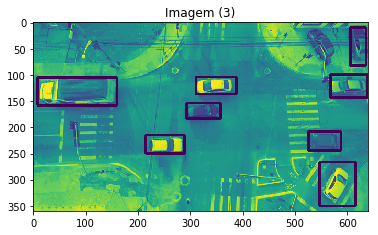

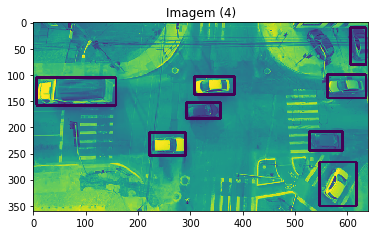

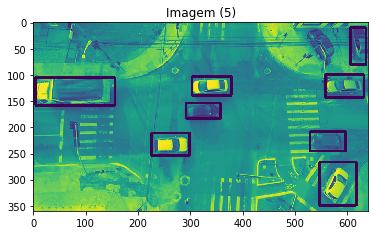

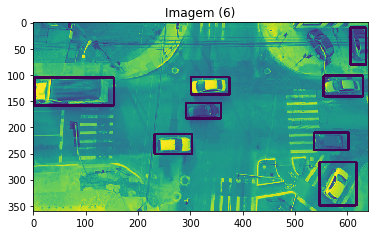

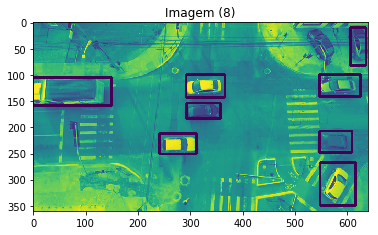

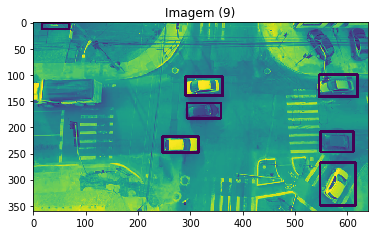

In [157]:
for filename in range(1, 10, 1):
   
    try:
        get_render(str(filename))
    except FileNotFoundError:
        continue

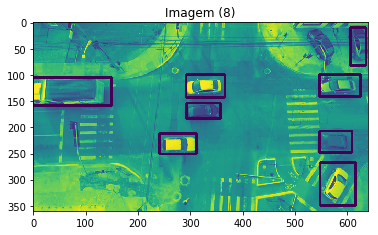

In [156]:
get_render(str(8))

In [105]:
df['height_object'] = df.ymax - df.ymin
df['width_object'] = df.xmax - df.xmin

In [109]:
height_object_mean = df.height_object.mean()
width_object_mean = df.width_object.mean()
print(width_object_mean, height_object_mean)

47.298941122308044 36.26855593636503


In [114]:
df.height_object.std()

22.308191690030203

In [115]:
df.width_object.std()

21.059270848925895

In [119]:
df.width_object.describe()

count    19549.000000
mean        47.298941
std         21.059271
min          3.000000
25%         32.000000
50%         43.000000
75%         64.000000
max        144.000000
Name: width_object, dtype: float64

In [120]:
df.height_object.describe()

count    19549.000000
mean        36.268556
std         22.308192
min          2.000000
25%         18.000000
50%         32.000000
75%         44.000000
max        118.000000
Name: height_object, dtype: float64

In [137]:
width_object_min = (df.width_object.std() / 2) + df.width_object.min()
height_object_min = (df.height_object.std() / 2) + df.height_object.min()

In [134]:
df = df[(df.width_object > width_object_min) & (df.height_object > height_object_min)]

In [144]:
df.area_object.min()

64

In [145]:
df.area_object.std()


2083.183524061275

In [139]:
df.width_object.min()

14

In [140]:
df.height_object.min()

14

In [148]:
df.area_object.describe()

count    19544.000000
mean      1968.495088
std       2083.183524
min         64.000000
25%        600.000000
50%       1160.000000
75%       2688.000000
max      16048.000000
Name: area_object, dtype: float64

In [155]:
df = df[df.area_object > 600]